In [1]:
import numpy as np
from PIL import Image
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.losses import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.datasets import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.preprocessing.text import * 
from tensorflow.keras.preprocessing.sequence import * 

In [3]:
train_path = r'C:\Users\44788\Desktop\OctaveML\lsun\train'
test_path = r'C:\Users\44788\Desktop\OctaveML\lsun\test'
val_path = r'C:\Users\44788\Desktop\OctaveML\lsun\valid'

In [10]:
def get_ImageDataGenerator():
    datagen = ImageDataGenerator(rescale=(1./255))
    return datagen

In [11]:
image_gen = get_ImageDataGenerator()

In [15]:
def get_generator(image_data_generator, directory, seed=None):
    generator = image_data_generator.flow_from_directory(directory,
                                                   target_size=(64,64),
                                                   batch_size=20,
                                                   classes = ['classroom', 'conference_room', 'church_outdoor'],
                                                   class_mode='categorical',
                                                   seed=seed)
    return generator

In [16]:
train_generator = get_generator(image_gen, train_path)
valid_generator = get_generator(image_gen, val_path)

Found 300 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


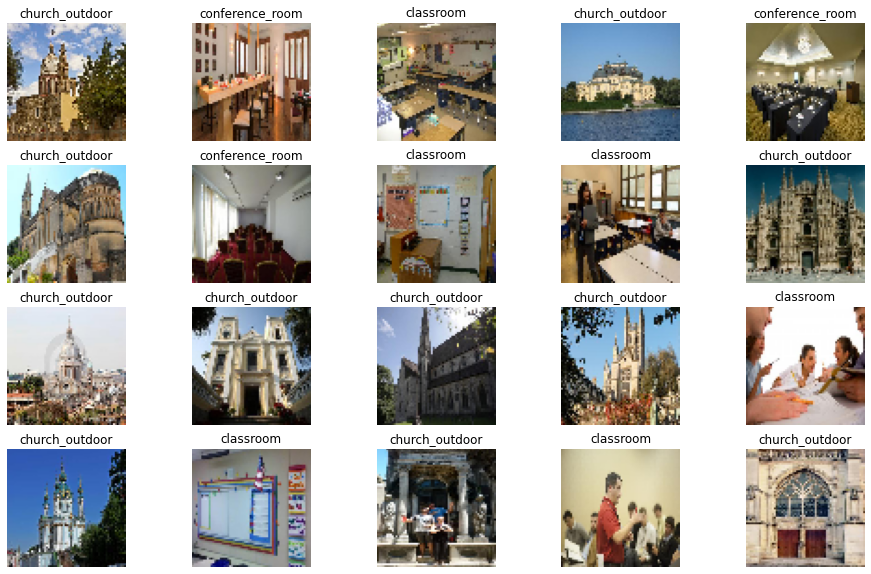

In [17]:
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])
lsun_classes = ['classroom', 'conference_room', 'church_outdoor']

plt.figure(figsize=(16,10))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [19]:
# reset generator
train_generator = get_generator(image_gen, train_path)

Found 300 images belonging to 3 classes.


In [20]:
def get_model(input_shape):
    inputs = Input(shape=(input_shape))
    x = Conv2D(8, (8,8), activation='relu', padding='SAME')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(4, (4,4), activation='relu', padding='SAME')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=0.0005),
                      loss = 'categorical_crossentropy',
                      metrics = ['categorical_accuracy'])
    return model 

In [21]:
lsun_model = get_model((64, 64, 3))
lsun_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         1544      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         516       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                16400 

In [22]:
def train_model(model, train_gen, valid_gen, epochs):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
    reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001)
    history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=epochs,
                    callbacks=[early_stopping, reduce_LR])
    return history

In [23]:
history = train_model(lsun_model, train_generator, valid_generator, epochs=3)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/15 [==============================] - ETA: 0s - loss: 1.1211 - categorical_accuracy: 0.2593WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000201F4254828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERB

In [24]:
def get_ImageDataGenerator_augmented():
    datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range=30, 
                                brightness_range=(0.5, 1.5),
                                horizontal_flip=True,) 
    return datagen

Found 300 images belonging to 3 classes.


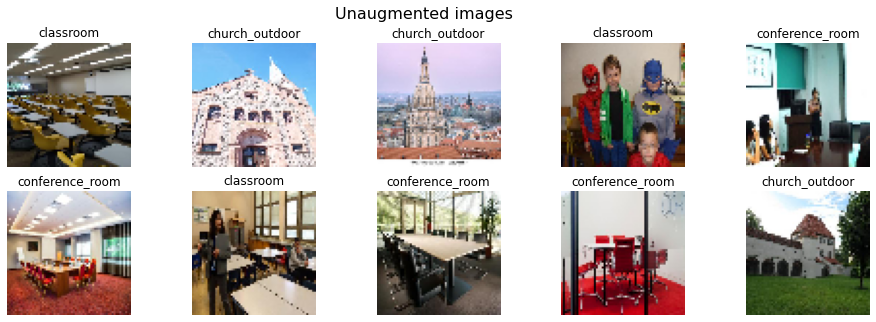

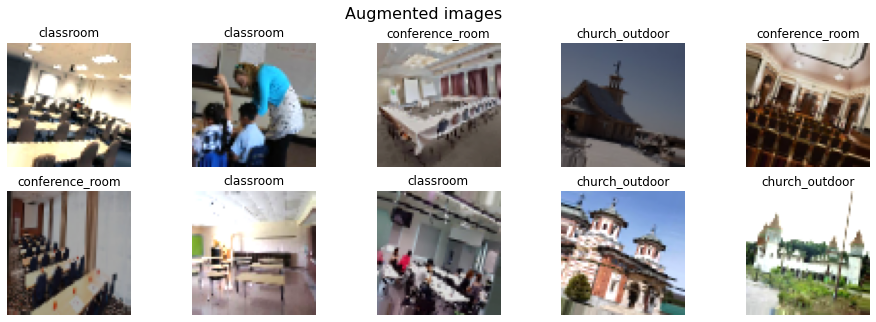

In [26]:
image_gen_aug = get_ImageDataGenerator_augmented()
train_generator_aug = get_generator(image_gen_aug, train_path, seed=10)
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(lsun_classes[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(lsun_classes[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

# Part 2: tf.data

In [27]:
from tensorflow.keras.datasets import cifar100
(training_features, training_labels), (test_features, test_labels) = cifar10.load_data()

In [28]:
def create_dataset(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [30]:
train_dataset = create_dataset(training_features, training_labels)
test_dataset = create_dataset(test_features, test_labels)

In [31]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))
(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))


In [42]:
# tf.math.equal: Returns the truth value of (x == y) element-wise.
# tf.cast: Casts a tensor to a new type.
# tf.math.reduce_any: Computes the "logical or" of elements across dimensions of a tensor.
# like np.any: Test whether any array element along a given axis evaluates to True.

def filter_classes(dataset, classes):
    def filter_auxilary(image, label):
        return tf.math.reduce_any(tf.equal(label, classes))
    
    return dataset.filter(filter_auxilary)

In [43]:
train_dataset = filter_classes(train_dataset, cifar_classes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [44]:
def map_labels(dataset):
    def map_auxilary(image,label):
        if label == 0:
            return (image, tf.constant([1., 0., 0.]))
        elif label == 29:
            return (image, tf.constant([0., 1., 0.]))
        else:
            return (image, tf.constant([0., 0., 1.]))
        
    return dataset.map(map_auxilary)

In [45]:
def map_images(dataset):
    def map_auxillary(image, label):
        image = image/255
        image = tf.reduce_mean(image, axis = 2, keepdims= True)
        return image, label
    
    return dataset.map(map_auxillary)